<a href="https://colab.research.google.com/github/jayantdahiya/Deep-Facial-Recognition/blob/main/Notebook1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python matplotlib

In [2]:
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [4]:
POS_PATH = os.path.join('/content/drive/MyDrive/Colab/Deep-Facial-Recognition-Application/data', '/content/drive/MyDrive/Colab/Deep-Facial-Recognition-Application/data/positive')
NEG_PATH = os.path.join('/content/drive/MyDrive/Colab/Deep-Facial-Recognition-Application/data', '/content/drive/MyDrive/Colab/Deep-Facial-Recognition-Application/data/negative')
ANC_PATH = os.path.join('/content/drive/MyDrive/Colab/Deep-Facial-Recognition-Application/data', '/content/drive/MyDrive/Colab/Deep-Facial-Recognition-Application/data/anchor')
# os.makedirs(POS_PATH)
# os.makedirs(NEG_PATH)
# os.makedirs(ANC_PATH)

In [5]:
# for directory in os.listdir('/content/drive/MyDrive/Colab/Deep-Facial-Recognition-Application/lfw'):
#   for file in os.listdir(os.path.join('/content/drive/MyDrive/Colab/Deep-Facial-Recognition-Application/lfw', directory)):
#     EX_PATH = os.path.join('/content/drive/MyDrive/Colab/Deep-Facial-Recognition-Application/lfw', directory, file)
#     NEW_PATH = os.path.join(NEG_PATH, file)
#     os.replace(EX_PATH, NEW_PATH)

In [6]:
#Getting image directory
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)


In [7]:
dir_test = anchor.as_numpy_iterator()

In [8]:
print(dir_test.next())

b'/content/drive/MyDrive/Colab/Deep-Facial-Recognition-Application/data/anchor/68b58f0a-70da-11ec-882c-cae6cca50a85.jpg'


In [9]:
#function to decode image with values between 0 and 1
def preprocess(file_path):
  byte_img = tf.io.read_file(file_path)
  img = tf.io.decode_jpeg(byte_img)
  img = tf.image.resize(img, (100,100))
  img = img/255.0
  return img

In [10]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [11]:
data

<ConcatenateDataset shapes: ((), (), ()), types: (tf.string, tf.string, tf.float32)>

In [12]:
sample = data.as_numpy_iterator()
example = sample.next()
example

(b'/content/drive/MyDrive/Colab/Deep-Facial-Recognition-Application/data/anchor/45f40afa-70da-11ec-882c-cae6cca50a85.jpg',
 b'/content/drive/MyDrive/Colab/Deep-Facial-Recognition-Application/data/positive/ae344828-70da-11ec-882c-cae6cca50a85.jpg',
 1.0)

In [13]:
def preprocess_twin(input_img, validation_img, label):
  return(preprocess(input_img), preprocess(validation_img), label)

In [14]:
res = preprocess_twin(*example)

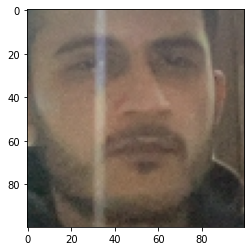

In [15]:
plt.imshow(res[1])

In [16]:
#Data pipeline 
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size = 1024)

In [17]:
samples=data.as_numpy_iterator()

In [18]:
#Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [19]:
train_samples = train_data.as_numpy_iterator()

In [20]:
train_sample = train_samples.next()

In [21]:
len(train_sample)

3

In [22]:
train_sample

(array([[[[0.88186276, 0.8485294 , 0.7985294 ],
          [0.72083336, 0.7002451 , 0.6610294 ],
          [0.49656862, 0.4612745 , 0.42794117],
          ...,
          [0.36936274, 0.34877452, 0.3625    ],
          [0.39828432, 0.36593136, 0.37083334],
          [0.40857843, 0.36936274, 0.36544117]],
 
         [[0.8872549 , 0.8539216 , 0.8039216 ],
          [0.6987745 , 0.6723039 , 0.6281863 ],
          [0.47401962, 0.4377451 , 0.40392157],
          ...,
          [0.34436274, 0.32647058, 0.3392157 ],
          [0.39803922, 0.36838236, 0.37230393],
          [0.39313725, 0.3617647 , 0.35392156]],
 
         [[0.89142156, 0.8522059 , 0.80514705],
          [0.71593136, 0.68259805, 0.64142156],
          [0.46862745, 0.42058823, 0.38602942],
          ...,
          [0.32671568, 0.31691176, 0.32671568],
          [0.36617646, 0.34460783, 0.34558824],
          [0.39313725, 0.35882354, 0.35980392]],
 
         ...,
 
         [[0.10294118, 0.14019608, 0.12745099],
          [0.08455

In [23]:
len(train_sample[0])

16

In [24]:
#testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [25]:
def make_embedding():
  inp = Input(shape=(100,100,3), name='input image')

  #First block
  c1 = Conv2D(64, (10,10), activation='relu')(inp)
  m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

  #Second block
  c2 = Conv2D(128, (7,7), activation='relu')(m1)
  m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

  #Third block
  c3 = Conv2D(128, (4,4), activation='relu')(m2)
  m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

  #Final Embedding block
  c4 = Conv2D(256, (4,4), activation='relu')(m3)
  f1 = Flatten()(c4)
  d1 = Dense(4096, activation='sigmoid')(f1)

  return Model(inputs=[inp], outputs=[d1], name='embedding')

In [32]:
embedding = make_embedding()

In [33]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

In [30]:
#Siamese L1 Distance class
class L1Dist(Layer):
  
  #Init method - inheritance
  def __init__(self, **kwargs):
    super().__init__()

  #Similarity calculation
  def call(self, input_embedding, validation_embedding):
    return tf.math.abs(input_embedding - validation_embedding)

In [31]:
l1 = L1Dist()

In [34]:
def make_siamese_model():

  #Anchor img input into the network
  input_img = Input(name='input_img', shape=(100,100,3))

  #Validation img in the network
  validation_img = Input(name='validation_img', shape=(100,100,3))

  #Combine siamese distance components
  siamese_layer = L1Dist()
  siamese_layer._name = 'distance'
  distances = siamese_layer(embedding(input_img), embedding(validation_img))

  #classification layer
  classifier = Dense(1, activation='sigmoid')(distances)

  return Model(inputs=[input_img, validation_img], outputs=classifier, name='Siamese_Network')